## Experiment E3: GPT-5.1 vs Orchestrator-8B Comparison
- Date: 2025-01-29
- Author: akshay@getseer.dev

### 1. Hypothesis
- **$H_0$:** GPT-5.1 and Orchestrator-8B perform equivalently on agentic tool-using tasks.
- **$H_1$:** Orchestrator-8B (specialized orchestrator) outperforms GPT-5.1 on complex multi-turn agentic tasks.

### 2. Experimental Setup
* **Environment:** Docker (Linux) + Mac (MLX API server)
* **Workload:** Agentic tasks requiring tool orchestration
* **Agent Architecture:** LangGraph ReAct Agent with LLM-as-Judge evaluation
* **Variables:**
    * *Independent:* LLM model (GPT-5.1 vs Orchestrator-8B)
    * *Controlled:* Agent (LangGraph ReAct), Tools (Composio MCP), Evaluation (LLM-as-Judge)
    * *Dependent:* 
        - Task success rate
        - Token usage (input/output tokens)
        - Agent performance metrics (score, groundedness, confabulation)

### 3. Procedure
1. **Setup:** 
   - Fetch Composio MCP tools per task
   - Initialize both models (GPT-5.1 via API, Orchestrator-8B via MLX API)
   - Initialize LangGraph ReAct agent
   - Initialize LLM-as-Judge evaluator
2. **Run:** 
   - For each task, run experiments with both models
   - Execute tasks using the ReAct agent
   - Track token usage for both models
   - Evaluate responses using LLM-as-Judge
3. **Analysis:** 
   - Compare task success rates
   - Compare token usage and costs
   - Analyze agent performance metrics

### 4. Evaluation Metrics
- **Task Success Rate:** Percentage of tasks completed successfully
- **Score:** LLM-as-Judge score (0.0-1.0)
- **Token Usage:** Input/output tokens per model
- **Groundedness:** Whether response is grounded in tool outputs
- **Confabulation:** Whether agent claimed success without evidence

## Prerequisites


In [1]:
%pip install matplotlib seaborn pandas numpy langgraph langchain-core langchain-openai requests


Note: you may need to restart the kernel to use updated packages.


## Import Statements


In [2]:
import os
import json
import re
import logging
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.tools import BaseTool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from composio import Composio
from composio_langchain import LangchainProvider
from langchain.agents import create_agent

load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
sns.set_theme(style="whitegrid")


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
import re
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import BaseMessage, AIMessage
from langchain_core.outputs import ChatGeneration, ChatResult
from typing import List, Any, Optional
from pydantic import ConfigDict


class ReasoningTokenStripper(BaseChatModel):
    """
    Wrapper that strips reasoning tokens (<think>, <think>, etc.) 
    from Orchestrator-8B responses to ensure tool calls are properly parsed.
    """
    model_config = ConfigDict(arbitrary_types_allowed=True, extra='allow')
    
    def __init__(self, base_model: BaseChatModel, **kwargs):
        # Initialize with extra='allow' so we can store base_model
        super().__init__(**kwargs)
        # Store base_model as a regular attribute (allowed with extra='allow')
        object.__setattr__(self, 'base_model', base_model)
        
    def _strip_reasoning_tokens(self, text: str) -> str:
        """Remove reasoning tokens and tags from response text."""
        if not text:
            return text
        
        # Remove <think>...</think> blocks (with any whitespace)
        text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL | re.IGNORECASE)
        
        # Remove standalone tags (unclosed)
        text = re.sub(r'</?redacted_reasoning>', '', text, flags=re.IGNORECASE)
        text = re.sub(r'</?think>', '', text, flags=re.IGNORECASE)
        text = re.sub(r'</?reasoning>', '', text, flags=re.IGNORECASE)
        
        # Clean up extra whitespace and newlines
        text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)
        text = text.strip()
        
        return text
    
    def _generate(self, messages: List[BaseMessage], stop: Optional[List[str]] = None, **kwargs: Any) -> ChatResult:
        """Generate response and strip reasoning tokens."""
        result = self.base_model._generate(messages, stop=stop, **kwargs)
        
        # Strip reasoning tokens from all generations
        for generation in result.generations:
            if isinstance(generation, ChatGeneration):
                if hasattr(generation, 'message') and isinstance(generation.message, AIMessage):
                    if generation.message.content:
                        original_content = generation.message.content
                        cleaned_content = self._strip_reasoning_tokens(str(original_content))
                        
                        # Only update if content changed (to preserve tool_calls if present)
                        if cleaned_content != original_content:
                            # Create new AIMessage with cleaned content but preserve tool_calls
                            generation.message = AIMessage(
                                content=cleaned_content,
                                tool_calls=getattr(generation.message, 'tool_calls', None),
                                tool_call_id=getattr(generation.message, 'tool_call_id', None),
                                response_metadata=getattr(generation.message, 'response_metadata', None),
                            )
        
        return result
    
    def invoke(self, input: List[BaseMessage], config: Optional[Any] = None, **kwargs: Any) -> BaseMessage:
        """Invoke model and strip reasoning tokens from response."""
        response = self.base_model.invoke(input, config=config, **kwargs)
        
        if isinstance(response, AIMessage) and response.content:
            original_content = str(response.content)
            cleaned_content = self._strip_reasoning_tokens(original_content)
            
            if cleaned_content != original_content:
                # Preserve tool_calls and other attributes
                return AIMessage(
                    content=cleaned_content,
                    tool_calls=getattr(response, 'tool_calls', None),
                    tool_call_id=getattr(response, 'tool_call_id', None),
                    response_metadata=getattr(response, 'response_metadata', None),
                )
        
        return response
    
    def bind_tools(self, tools, **kwargs):
        """Delegate bind_tools to base model and wrap the result."""
        bound_model = self.base_model.bind_tools(tools, **kwargs)
        # Return a new wrapper with the bound model
        return ReasoningTokenStripper(bound_model)
    
    @property
    def _llm_type(self) -> str:
        return "reasoning_token_stripper"
    
    @property
    def model_name(self) -> str:
        """Delegate model_name to base model."""
        return getattr(self.base_model, 'model_name', 'orchestrator-8b')

# RunPod proxy URL (exposes port 8000)
orchestrator_api_url = "https://c1nw2aqzf8ifzc-8000.proxy.runpod.net"

# Test connection first
import requests
try:
    response = requests.get(f"{orchestrator_api_url}/health", timeout=5)
    if response.status_code == 200:
        print(f"✅ Orchestrator server found at {orchestrator_api_url}")
        print(f"   Status: {response.json()}")
    else:
        print(f"⚠️ Orchestrator server returned status {response.status_code}")
        orchestrator_api_url = None
except Exception as e:
    print(f"⚠️ Could not connect to Orchestrator server at {orchestrator_api_url}: {e}")
    print("   Make sure orchestrator_vllm_simple.py is running!")
    orchestrator_api_url = None

models_to_compare = {
    "gpt-5.1": ChatOpenAI(model="gpt-5.1", reasoning={"effort": "low"}),
}

if orchestrator_api_url:
    from langchain_openai import ChatOpenAI
    import os

    # Create base Orchestrator model
    base_orchestrator = ChatOpenAI(
        model="orchestrator-8b",  # Model name (doesn't matter, server uses loaded model)
        base_url=f"{orchestrator_api_url}/v1",  # Our FastAPI server endpoint
        api_key="not-needed",  # No auth needed
        temperature=0.2,
        max_tokens=4096,
        timeout=120,  # Increase timeout for slower responses
    )
    
    # Wrap Orchestrator model to strip reasoning tokens (double protection)
    # Server already strips, but this ensures clean responses in LangChain
    models_to_compare["orchestrator-8b"] = ReasoningTokenStripper(base_orchestrator)
    
    print("\n✅ Models initialized")
    print(f"   GPT-5.1: Ready")
    print(f"   Orchestrator-8B: Ready (with reasoning token stripping)")
else:
    print("\n⚠️ Orchestrator-8B not initialized (server not available)")
    print("   Continuing with GPT-5.1 only...")
    

✅ Orchestrator server found at https://c1nw2aqzf8ifzc-8000.proxy.runpod.net
   Status: {'status': 'healthy', 'model': 'nvidia/Orchestrator-8B', 'engine': 'vLLM'}

✅ Models initialized
   GPT-5.1: Ready
   Orchestrator-8B: Ready (with reasoning token stripping)


## Configuration & Setup


In [4]:
# --- Configuration ---
COMPOSIO_API_KEY = os.getenv("COMPOSIO_API_KEY")
COMPOSIO_USER_ID = os.getenv("COMPOSIO_USER_ID")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Experiment Parameters
NUM_RUNS = 4  # Number of runs per task per method (total runs = NUM_RUNS * 2 methods)
MAX_TOOLS_PER_TASK = 50  # Limit to prevent OpenAI context errors (max 128)
TOP_K_TOOLS = 10

# Experiment Tasks
# Simplified structure: only instruction, metric, and services are required
TASKS = [
    {
        "instruction": "Port a table present in Google Docs to Google Sheets. Document ID: 12ehk1ERYYq4xEIk1TuMKJqJXlNx-yDYOuN5EIgcQ74Q. Target Sheet ID: 1YF6Vrp9E0mvR5mpjeONzfdaCFx6WmQlkMm6BmPsag6U",
        "metric": "Check if Sheets API returned 'Success' with data.",
        "services": ["GOOGLEDOCS", "GOOGLESHEETS"]
    },
    # {
    #     "instruction": "create an asana ticket in asana workspace ID 1211928405122978 and project ID 1212223049809654. create a GitHub PR in https://github.com/seer-engg/buggy-coder, add commit, merge PR and update Asana.",
    #     "metric": "Check if PR merged and Asana task updated.",
    #     "services": ["GITHUB", "ASANA"]
    # },
    # {
    #     "instruction": "push the latest changes in https://github.com/seer-engg/buggy-coder main branch to docker hub",
    #     "metric": "Check for Docker image build confirmation.",
    #     "services": ["GITHUB", "DOCKER"]
    # },
    # {
    #     "instruction": "find akshay@getseer.dev's google calendar events for next day, then message a summary in #testing-testing channel and tag him too",
    #     "metric": "Check for slack message in #testing-testing channel",
    #     "services": ["GOOGLECALENDAR", "SLACK"]
    # },
    {
        "instruction": "remind akshay@getseer.dev to buy some groceries",
        "metric": "Check Gmail API logs for sent message count.",
        "services": ["GMAIL"]
    },
    {
        "instruction": "send good morning message to +1 646-371-6198 via telegram",
        "metric": "Check API response 200 OK from Telegram.",
        "services": ["TELEGRAM"]
    },
    {
        "instruction": "what are the latest trends going on twitter",
        "metric": "Check Twitter API for post results.",
        "services": ["TWITTER"]
    },
]

CACHED_SYSTEM_PROMPT = """
You are an expert AI Assistant and QA Auditor.
Your goal is to execute tasks using the provided tools and then reflect on your performance.

### CORE INSTRUCTIONS
1. **Analyze the Request**: Understand the user's intent and the success metric.
2. **Select Tools**: Choose the most appropriate tools from your available toolkit.
3. **Execute**: Run the tools and observe the output.
4. **Verify**: Check if the output satisfies the success metric.
5. **Reflect**: If a tool fails or produces unexpected results, analyze why and try a different approach.

### RESPONSE GUIDELINES
- Be concise and direct.
- Do not hallucinate tool outputs; only use what is returned by the tools.
- If a tool is missing, explicitly state that you cannot perform the task.
- Always check the tool output against the success metric before claiming success.
"""


In [5]:
# OPTIMIZED VERSION: Replace filter_tools_with_llm function with this optimized version
# This reduces Orchestrator-8B token usage significantly

def filter_tools_with_llm_optimized(
    task: Dict[str, Any],
    all_tools: List[BaseTool],
    model,
    top_k: int = 10
) -> tuple[List[BaseTool], Dict[str, Any]]:
    """Optimized version - uses shorter prompts for Orchestrator-8B."""
    model_name = getattr(model, 'model_name', 'unknown')
    is_orchestrator = 'orchestrator' in model_name.lower()
    
    # Prepare tool descriptions
    tool_descriptions = [{"name": tool.name, "description": tool.description or ""} for tool in all_tools]
    
    # Create optimized prompt based on model
    if is_orchestrator:
        # Ultra-concise prompt for Orchestrator (reduces reasoning/verbosity)
        prompt = f"""Task: {task['instruction']}
Metric: {task.get('metric', 'N/A')}

Select {top_k} tools from: {json.dumps([t['name'] for t in tool_descriptions], indent=0)}

Return ONLY JSON array: ["tool1", "tool2", ...]"""
    else:
        # Standard prompt for GPT models
        prompt = f"""You are a tool selection expert. Given a task and a list of available tools, select the most relevant tools needed to complete the task.

TASK:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AVAILABLE TOOLS ({len(all_tools)} total):
{json.dumps(tool_descriptions, indent=2)}

Select the top {top_k} most relevant tools for this task. Consider:
1. Which tools are directly required to complete the task?
2. Which tools might be needed as dependencies or helpers?
3. Rank tools by importance (most critical first)

Return a JSON array of tool names in order of relevance (most relevant first).
Format: ["tool_name_1", "tool_name_2", ...]
"""
    
    token_usage = {"input_tokens": 0, "output_tokens": 0}
    print(f"   📤 Sending tool selection request to LLM (model: {model_name})...")
    
    # Give Orchestrator enough tokens to complete the response (it may include reasoning)
    # Increased from 128 to 2048 to match GPT and allow for reasoning tokens
    max_tokens = 2048 if is_orchestrator else 1024
    try:
        response = model.invoke([HumanMessage(content=prompt)], max_tokens=max_tokens)
        print(f"   ⏳ Got response, parsing...")
    except Exception as e:
        print(f"   ❌ Error calling model: {e}")
        # Try to get raw response for debugging
        if is_orchestrator and hasattr(model, 'client'):
            try:
                # Try to make a direct request to see raw response
                import requests
                api_url = getattr(model, '_client', None)
                if api_url is None:
                    # Try to extract from base_url
                    base_url = getattr(model, 'base_url', None)
                    if base_url:
                        # Make a test request to see what we get
                        test_response = requests.post(
                            f"{base_url}/chat/completions",
                            json={
                                "messages": [{"role": "user", "content": "test"}],
                                "temperature": 0.2,
                                "max_tokens": 10
                            },
                            headers={"Authorization": f"Bearer {getattr(model, 'api_key', 'not-needed')}"},
                            timeout=10
                        )
                        print(f"   🔍 Raw HTTP response status: {test_response.status_code}")
                        print(f"   🔍 Raw HTTP response body: {test_response.text[:500]}")
            except Exception as debug_e:
                print(f"   ⚠️ Could not fetch raw response: {debug_e}")
        raise
    
    # Extract token usage
    token_found = False
    if hasattr(response, 'response_metadata') and response.response_metadata:
        usage = response.response_metadata.get('token_usage', {})
        if usage:
            token_usage["input_tokens"] = usage.get('prompt_tokens', 0) or usage.get('input_tokens', 0)
            token_usage["output_tokens"] = usage.get('completion_tokens', 0) or usage.get('output_tokens', 0)
            token_found = True
    
    # Parse content
    content = response.content if hasattr(response, 'content') else str(response)
    if isinstance(content, list):
        content = ' '.join([item.get('text', '') if isinstance(item, dict) else str(item) for item in content])
    
    if not token_found:
        token_usage["input_tokens"] = len(prompt) // 4
        token_usage["output_tokens"] = len(content) // 4
    else:
        print(f"   💰 Token usage: {token_usage['input_tokens']} input, {token_usage['output_tokens']} output")
    
    # Extract tool names (same logic as before)
    selected_tool_names = []
    json_match = re.search(r'\[[\s\S]*?\]', content)
    if json_match:
        try:
            selected_tool_names = json.loads(json_match.group().strip())
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Found JSON array with {len(selected_tool_names)} tools")
        except:
            pass
    
    if not selected_tool_names:
        try:
            selected_tool_names = json.loads(content)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Parsed entire content as JSON array")
        except:
            pass
    
    if not selected_tool_names:
        potential = re.findall(r'["\']?([A-Z_][A-Z0-9_]+)["\']?', content)
        tool_names_set = {tool.name for tool in all_tools}
        selected_tool_names = [t for t in potential if t in tool_names_set and t not in selected_tool_names][:top_k]
        if selected_tool_names:
            print(f"   ✅ Extracted {len(selected_tool_names)} tool names from text")
    
    selected_tool_names = selected_tool_names[:top_k]
    tool_map = {tool.name: tool for tool in all_tools}
    selected_tools = [tool_map[t] for t in selected_tool_names if t in tool_map]
    selected_tools = selected_tools[:top_k]
    
    logger.info(f"LLM selected {len(selected_tools)} tools from {len(all_tools)} available")
    return selected_tools, token_usage

# Replace the old function with the optimized one
filter_tools_with_llm = filter_tools_with_llm_optimized


## Helper Classes & Functions


In [6]:
def _clean_composio_response(response: Any) -> Any:
    """Unwrap nested Composio response format."""
    if isinstance(response, dict):
        if response.get("successful") is True:
            data_outer = response.get("data")
            if isinstance(data_outer, dict):
                data_inner = data_outer.get("data")
                if data_inner is not None:
                    return data_inner
    return response

class ComposioToolWrapper(BaseTool):
    """Wrapper for Composio tools to clean up response structure."""
    original_tool: BaseTool
    
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(self.original_tool.invoke(kwargs))
        
    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(await self.original_tool.ainvoke(kwargs))

def get_mcp_tools(service_names: List[str], api_key: str = None, user_id: str = "default") -> List[BaseTool]:
    """Get MCP tools using Composio SDK."""
    composio_client = Composio(api_key=api_key, provider=LangchainProvider())
    # Limit to prevent OpenAI context errors
    tools = composio_client.tools.get(
        toolkits=service_names, 
        user_id=user_id, 
        limit=MAX_TOOLS_PER_TASK
    )
    
    wrapped_tools = []
    for tool in tools:
        wrapper = ComposioToolWrapper(
            name=tool.name,
            description=tool.description,
            args_schema=tool.args_schema,
            original_tool=tool
        )
        wrapped_tools.append(wrapper)
    return wrapped_tools

def convert_toolhub_to_langchain(toolhub_tools: List[Dict[str, Any]], all_tools_map: Dict[str, BaseTool]) -> List[BaseTool]:
    """
    Convert ToolHub's returned tool dictionaries back to LangChain BaseTool objects.
    
    Args:
        toolhub_tools: List of tool dictionaries from ToolHub.query()
        all_tools_map: Mapping of tool names to their original LangChain BaseTool instances
    
    Returns:
        List of LangChain BaseTool objects that can be used by the agent
    """
    langchain_tools = []
    missing_tools = []
    
    for tool_dict in toolhub_tools:
        tool_name = tool_dict.get('name')
        if tool_name and tool_name in all_tools_map:
            # Use the original executable tool
            langchain_tools.append(all_tools_map[tool_name])
        else:
            missing_tools.append(tool_name)
            logger.warning(f"ToolHub returned tool '{tool_name}' but executable not found in all_tools_map")
    
    if missing_tools:
        print(f"⚠️ Warning: {len(missing_tools)} tools from ToolHub couldn't be mapped: {missing_tools[:3]}...")
        print(f"   Available tool names in map: {list(all_tools_map.keys())[:5]}...")
    
    return langchain_tools

def filter_tools_with_llm(
    task: Dict[str, Any],
    all_tools: List[BaseTool],
    model: ChatOpenAI,
    top_k: int = 10
) -> tuple[List[BaseTool], Dict[str, Any]]:
    """
    Use LLM to filter and rank tools from all available tools.
    
    Args:
        task: Task dictionary with instruction and metric
        all_tools: List of all available tools
        model: LLM model to use for filtering
        top_k: Number of tools to select
    
    Returns:
        Tuple of (selected_tools, token_usage_info)
    """
    from langchain_core.messages import SystemMessage, HumanMessage
    from langchain_core.utils.function_calling import convert_to_openai_tool
    import json
    
    # Prepare tool descriptions for LLM
    tool_descriptions = []
    for tool in all_tools:
        tool_descriptions.append({
            "name": tool.name,
            "description": tool.description or ""
        })
    
    # Create prompt for LLM tool selection
    prompt = f"""You are a tool selection expert. Given a task and a list of available tools, select the most relevant tools needed to complete the task.

TASK:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AVAILABLE TOOLS ({len(all_tools)} total):
{json.dumps(tool_descriptions, indent=2)}

Select the top {top_k} most relevant tools for this task. Consider:
1. Which tools are directly required to complete the task?
2. Which tools might be needed as dependencies or helpers?
3. Rank tools by importance (most critical first)

Return a JSON array of tool names in order of relevance (most relevant first).
Format: ["tool_name_1", "tool_name_2", ...]
"""
    
    # Track token usage
    token_usage = {"input_tokens": 0, "output_tokens": 0}

    # Get response from LLM
    print(f"   📤 Sending tool selection request to LLM (model: {model.model_name if hasattr(model, 'model_name') else 'unknown'})...")
    response = model.invoke([HumanMessage(content=prompt)])
    
    # Extract token usage if available (try multiple locations)
    token_found = False
    if hasattr(response, 'response_metadata') and response.response_metadata:
        usage = response.response_metadata.get('token_usage', {})
        if usage:
            token_usage["input_tokens"] = usage.get('prompt_tokens', 0) or usage.get('input_tokens', 0)
            token_usage["output_tokens"] = usage.get('completion_tokens', 0) or usage.get('output_tokens', 0)
            token_found = token_usage["input_tokens"] > 0 or token_usage["output_tokens"] > 0
    
    # Try alternative locations for token usage (some models store it differently)
    if not token_found and hasattr(response, 'usage'):
        usage = response.usage
        if hasattr(usage, 'prompt_tokens'):
            token_usage["input_tokens"] = usage.prompt_tokens
            token_usage["output_tokens"] = usage.completion_tokens
            token_found = True
    
    # Parse tool names from response
    # Handle case where content might be a list (LangChain AIMessage.content can be a list)
    if hasattr(response, 'content'):
        content_raw = response.content
        if isinstance(content_raw, list):
            # Extract text from dict items (GPT 5.1 returns list of dicts with 'type' and 'text' keys)
            text_parts = []
            for item in content_raw:
                if isinstance(item, dict):
                    # Check for 'text' key (GPT 5.1 format)
                    if 'text' in item:
                        text_parts.append(item['text'])
                    # Also handle direct string values
                    elif 'content' in item:
                        text_parts.append(item['content'])
                elif isinstance(item, str):
                    text_parts.append(item)
            content = ' '.join(text_parts) if text_parts else str(content_raw)
        elif not isinstance(content_raw, str):
            content = str(content_raw)
        else:
            content = content_raw
    else:
        content = str(response)
    
    # Estimate tokens if not found (rough approximation)
    if not token_found:
        # Rough estimate: ~4 chars per token
        estimated_input = len(prompt) // 4
        estimated_output = len(content) // 4 if content else 0
        token_usage["input_tokens"] = estimated_input
        token_usage["output_tokens"] = estimated_output
        print(f"   ⚠️ Token usage not available, estimated: {estimated_input} input, {estimated_output} output")
    else:
        print(f"   💰 Token usage: {token_usage['input_tokens']} input, {token_usage['output_tokens']} output")
    
    # Check if content is empty
    if not content or not content.strip():
        print(f"   ❌ Empty response from LLM!")
        raise ValueError("Empty response from LLM")
    
    # Try to extract JSON array from response
    import re
    selected_tool_names = []
    
    # Debug: Print first 500 chars of response to see what we got
    print(f"   🔍 LLM Response preview: {content[:500]}...")
    
    # Method 1: Try to find JSON array in response (handle multi-line JSON)
    # Use a more robust regex that handles nested brackets and multi-line
    json_match = re.search(r'\[[\s\S]*?\]', content)
    if json_match:
        try:
            json_str = json_match.group().strip()
            selected_tool_names = json.loads(json_str)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Found JSON array with {len(selected_tool_names)} tools")
            else:
                selected_tool_names = []
        except json.JSONDecodeError as e:
            print(f"   ⚠️ JSON parse error: {e}")
            # Try to fix common JSON issues (trailing commas, etc.)
            try:
                # Remove trailing commas before closing bracket
                json_str_fixed = re.sub(r',\s*\]', ']', json_str)
                selected_tool_names = json.loads(json_str_fixed)
                if isinstance(selected_tool_names, list):
                    print(f"   ✅ Fixed JSON and parsed {len(selected_tool_names)} tools")
                else:
                    selected_tool_names = []
            except:
                selected_tool_names = []
    
    # Method 2: If no array found, try parsing entire content as JSON
    if not selected_tool_names:
        try:
            selected_tool_names = json.loads(content)
            if isinstance(selected_tool_names, list):
                print(f"   ✅ Parsed entire content as JSON array with {len(selected_tool_names)} tools")
            else:
                selected_tool_names = []
        except (json.JSONDecodeError, TypeError):
            pass
    
    # Method 3: Extract tool names from text using pattern matching
    if not selected_tool_names:
        # Look for tool names in the content
        tool_name_pattern = r'["\']?([A-Z_][A-Z0-9_]+)["\']?'
        potential_tools = re.findall(tool_name_pattern, content)
        
        # Match against actual tool names
        tool_names_set = {tool.name for tool in all_tools}
        for potential_tool in potential_tools:
            if potential_tool in tool_names_set and potential_tool not in selected_tool_names:
                selected_tool_names.append(potential_tool)
        
        if selected_tool_names:
            print(f"   ✅ Extracted {len(selected_tool_names)} tool names from text")
    
    # Method 4: Last resort - keyword matching
    if not selected_tool_names:
        print(f"   ⚠️ No tools found via JSON/text extraction, trying keyword matching...")
        for tool in all_tools:
            # Check if tool name or key parts appear in content
            tool_words = tool.name.split('_')
            if any(word.lower() in content.lower() for word in tool_words if len(word) > 3):
                if tool.name not in selected_tool_names:
                    selected_tool_names.append(tool.name)
            if len(selected_tool_names) >= top_k:
                break
        
        if selected_tool_names:
            print(f"   ✅ Found {len(selected_tool_names)} tools via keyword matching")
    
    # Limit to top_k
    selected_tool_names = selected_tool_names[:top_k]
    
    if not selected_tool_names:
        print(f"   ❌ Failed to extract any tool names from LLM response")
        print(f"   📝 Full response: {content}")
    
    # Convert tool names to actual tool objects
    tool_map = {tool.name: tool for tool in all_tools}
    selected_tools = []
    for tool_name in selected_tool_names:
        if tool_name in tool_map:
            selected_tools.append(tool_map[tool_name])
        elif isinstance(tool_name, str):
            # Try fuzzy matching
            for available_tool in all_tools:
                if tool_name.lower() == available_tool.name.lower() or tool_name.lower() in available_tool.name.lower():
                    selected_tools.append(available_tool)
                    break
    
    # Limit to top_k
    selected_tools = selected_tools[:top_k]
    
    logger.info(f"LLM selected {len(selected_tools)} tools from {len(all_tools)} available")
    
    return selected_tools, token_usage
    

class AgentEvaluationResult(BaseModel):
    """Structured output for LLM-as-judge evaluation."""
    score: float = Field(description="Score from 0.0 to 1.0 indicating how well the agent completed the task")
    status: str = Field(description="Status: 'PASS', 'PARTIAL', or 'FAIL'")
    reason: str = Field(description="Detailed explanation of the evaluation decision. This field is mandatory and must provide clear reasoning.")
    confabulation: bool = Field(description="True if agent claimed success without actually executing tools or without evidence")
    tool_calls: List[str] = Field(description="List of tool names that were actually called by the agent")
    tool_hallucination: bool = Field(description="True if agent attempted to call tools that don't exist in the available tools list")
    groundedness: bool = Field(description="True if the agent's final response is grounded in tool outputs rather than hallucinated")


def evaluate_agent_response(
    task: Dict[str, Any], 
    agent_messages: List, 
    tools: List[BaseTool],
    evaluator_model: ChatOpenAI = None
) -> Dict[str, Any]:
    """
    Use LLM-as-judge to evaluate agent's response against success metric.
    Uses structured output to ensure mandatory reason field.
    """
    from langchain_core.messages import AIMessage, ToolMessage
    
    # Extract tool calls and messages for evaluation
    tool_calls_made = []
    tool_outputs = []
    final_response = ""
    available_tool_names = [t.name for t in tools]
    
    # Process messages to extract tool calls, tool outputs, and final response
    for msg in agent_messages:
        if isinstance(msg, AIMessage):
            # Check for tool calls
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tool_call in msg.tool_calls:
                    tool_name = tool_call.get('name', '') if isinstance(tool_call, dict) else getattr(tool_call, 'name', '')
                    if tool_name:
                        tool_calls_made.append(tool_name)
            # Check for final response (no tool calls)
            elif hasattr(msg, 'content') and msg.content and not final_response:
                final_response = msg.content
        elif isinstance(msg, ToolMessage):
            # Collect tool outputs for groundedness check
            if hasattr(msg, 'content'):
                tool_outputs.append(str(msg.content))
    
    # Fallback: use last message if no final response found
    if not final_response and agent_messages:
        last_msg = agent_messages[-1]
        if hasattr(last_msg, 'content'):
            final_response = str(last_msg.content)
    
    # Prepare context for LLM evaluator
    tool_calls_str = ", ".join(tool_calls_made) if tool_calls_made else "None"
    tool_outputs_str = "\n".join(tool_outputs[:5]) if tool_outputs else "No tool outputs available"
    available_tools_str = ", ".join(available_tool_names[:20])  # Limit to avoid context overflow
    
    # Create evaluation prompt
    evaluation_prompt = f"""You are an expert evaluator assessing an AI agent's performance on a task.

TASK INSTRUCTION:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AGENT'S FINAL RESPONSE:
{final_response}

TOOLS CALLED BY AGENT:
{tool_calls_str}

AVAILABLE TOOLS (sample):
{available_tools_str}

TOOL OUTPUTS (first 5):
{tool_outputs_str}

EVALUATION CRITERIA:
1. **Confabulation**: Did the agent claim success without actually executing tools or without evidence from tool outputs?
2. **Tool Hallucination**: Did the agent attempt to call tools that don't exist in the available tools list?
3. **Groundedness**: Is the agent's response grounded in actual tool outputs rather than hallucinated information?
4. **Task Completion**: Did the agent successfully complete the task according to the success metric?
5. **Tool Usage**: Did the agent use appropriate tools to accomplish the task?

SCORING GUIDE:
- Score 1.0: Task fully completed, all criteria met, response grounded in tool outputs
- Score 0.7-0.9: Task partially completed, minor issues, mostly grounded
- Score 0.4-0.6: Task attempted but significant issues (wrong tools, partial completion)
- Score 0.0-0.3: Task failed, confabulation, hallucination, or no tool usage

STATUS GUIDE:
- PASS: Score >= 0.8, task completed successfully
- PARTIAL: Score 0.4-0.7, task attempted but not fully completed
- FAIL: Score < 0.4, task failed or not attempted

Evaluate the agent's performance and provide a detailed reason explaining your decision."""

    # Use provided evaluator model or create default
    if evaluator_model is None:
        evaluator_model = ChatOpenAI(
            model="gpt-5.1",
            temperature=0.0,  # Deterministic evaluation
        )
    
    # Get structured output
    structured_llm = evaluator_model.with_structured_output(AgentEvaluationResult)
    
    result = structured_llm.invoke(evaluation_prompt)
    
    # Convert Pydantic model to dict
    evaluation_dict = {
        "score": result.score,
        "status": result.status,
        "reason": result.reason,  # Mandatory field
        "confabulation": result.confabulation,
        "tool_calls": result.tool_calls if result.tool_calls else tool_calls_made,
        "tool_hallucination": result.tool_hallucination,
        "groundedness": result.groundedness,
        "final_response": final_response
    }
    
    return evaluation_dict


## Evaluation Logic


In [7]:
def run_evaluation(
    task: Dict[str, Any], 
    task_id: int, 
    run_id: int, 
    all_tools: List[BaseTool], 
    model,
    model_name: str
):
    """Run a single evaluation iteration using LangGraph ReAct agent."""
    print(f"\n🔄 Task {task_id + 1} Run {run_id} ({model_name})")
    logger.info(f"Task {task_id + 1} Run {run_id} ({model_name}): {task['instruction'][:50]}...")
    
    # Select tools using LLM
    try:
        selected_tools, selection_tokens = filter_tools_with_llm(task, all_tools, model, top_k=TOP_K_TOOLS)
        selected_tool_names = [t.name for t in selected_tools]
        print(f"✅ Selected {len(selected_tools)} tools | Tokens: {selection_tokens['input_tokens']}+{selection_tokens['output_tokens']}")
    except Exception as e:
        print(f"❌ Tool selection failed: {e}")
        raise
    
    # Filter tools with names > 64 chars
    valid_tools = [t for t in selected_tools if len(t.name) <= 64]
    if len(valid_tools) < len(selected_tools):
        print(f"   ⚠️ Filtered {len(selected_tools) - len(valid_tools)} tools with long names")
    
    if not valid_tools:
        valid_tools = all_tools[:TOP_K_TOOLS]
        selected_tool_names = [t.name for t in valid_tools]
    
    # Create agent
    system_prompt = f"""{CACHED_SYSTEM_PROMPT}

TASK CONTEXT:
- Task: {task['instruction']}
- Success Metric: {task['metric']}

Remember: You must actually execute tools to complete this task. Do not claim success without tool execution.
"""
    agent = create_agent(model=model, tools=valid_tools, system_prompt=system_prompt)
    
    # Run agent
    result = agent.invoke({"messages": [HumanMessage(content=task['instruction'])]})
    agent_messages = result.get("messages", [])
    
    # Evaluate
    evaluation = evaluate_agent_response(task, agent_messages, valid_tools)
    
    return {
        "task_id": task_id + 1,
        "run_id": run_id,
        "model": model_name,
        "status": evaluation["status"],
        "score": evaluation["score"],
        "reason": evaluation["reason"],
        "confabulation": evaluation["confabulation"],
        "groundedness": evaluation["groundedness"],
        "tool_calls": evaluation.get("tool_calls", []),
        "tool_calls_count": len(evaluation.get("tool_calls", [])),
        "tools_provided": len(valid_tools),
        "tools_available": len(all_tools),
        "selection_input_tokens": selection_tokens.get("input_tokens", 0),
        "selection_output_tokens": selection_tokens.get("output_tokens", 0),
    }
    

## Run Experiments


In [8]:
import traceback

# Check if models are initialized
if 'models_to_compare' not in globals() or not models_to_compare:
    raise RuntimeError(
        "❌ models_to_compare is not defined or empty!\n"
        "   Please run Cell 5 (Model Initialization) first.\n"
        "   Make sure orchestrator_vllm_simple.py is running if you want to test Orchestrator-8B."
    )

results = []
tools_cache = {}
print(f"Starting: {len(TASKS)} tasks x {NUM_RUNS} runs x {len(models_to_compare)} models = {len(TASKS) * NUM_RUNS * len(models_to_compare)} total runs")

# Fetch tools
print("📦 Fetching tools...")
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    if services not in tools_cache:
        if services:
            print(f"  Fetching {services}...")
            tools_cache[services] = get_mcp_tools(list(services), api_key=COMPOSIO_API_KEY, user_id=COMPOSIO_USER_ID)
        else:
            tools_cache[services] = []

# Run experiments
print(f"\n🚀 Running experiments...")
EXPERIMENT_START_TIME = datetime.now()
for task_idx, task in enumerate(TASKS):
    services = tuple(sorted(task.get("services", [])))
    task_tools = tools_cache[services]
    
    print(f"\n{'='*60}")
    print(f"Task {task_idx + 1}: {task['instruction'][:50]}... ({len(task_tools)} tools)")
    print(f"{'='*60}")
    
    # Compare both models
    for model_name, model in models_to_compare.items():
        print(f"\n--- {model_name.upper()} ---")
        
        with ThreadPoolExecutor(max_workers=3) as executor:
             futures = {
                 executor.submit(run_evaluation, task, task_idx, i, task_tools, model, model_name): i
                 for i in range(1, NUM_RUNS + 1)
             }
             
             for future in as_completed(futures):
                 try:
                     result = future.result()
                     results.append(result)
                     print(f"  Run {result['run_id']}: {result['status']} (Score: {result['score']:.2f})")
                 except Exception as e:
                     print(f"  ❌ Error: {e}")
                     print(traceback.format_exc())

# Save results
if results:
    df = pd.DataFrame(results)
    df.to_csv("experiment_results.csv", index=False)
    print(f"\n✅ Experiment complete. Results saved to experiment_results.csv")
    print(f"Total runs: {len(results)}")
    
    # Show breakdown by model
    if 'models_to_compare' in globals() and models_to_compare:
        for model_name in models_to_compare.keys():
            count = len([r for r in results if r.get('model') == model_name])
            print(f"  - {model_name}: {count}")
    else:
        # Fallback: count by model from results
        model_counts = {}
        for r in results:
            model = r.get('model', 'unknown')
            model_counts[model] = model_counts.get(model, 0) + 1
        for model_name, count in model_counts.items():
            print(f"  - {model_name}: {count}")
else:
    print("\n⚠️ No results to save. Check for errors above.")

Starting: 4 tasks x 4 runs x 2 models = 32 total runs
📦 Fetching tools...
  Fetching ('GOOGLEDOCS', 'GOOGLESHEETS')...
  Fetching ('GMAIL',)...
  Fetching ('TELEGRAM',)...
  Fetching ('TWITTER',)...

🚀 Running experiments...

Task 1: Port a table present in Google Docs to Google Shee... (50 tools)

--- GPT-5.1 ---

🔄 Task 1 Run 1 (gpt-5.1)
   📤 Sending tool selection request to LLM (model: gpt-5.1)...

🔄 Task 1 Run 2 (gpt-5.1)
   📤 Sending tool selection request to LLM (model: gpt-5.1)...

🔄 Task 1 Run 3 (gpt-5.1)
   📤 Sending tool selection request to LLM (model: gpt-5.1)...
   ⚠️ Token usage not available, estimated: 3462 input, 83 output
   🔍 LLM Response preview: ["GOOGLEDOCS_GET_DOCUMENT_BY_ID",
 "GOOGLESHEETS_BATCH_UPDATE",
 "GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE",
 "GOOGLESHEETS_ADD_SHEET",
 "GOOGLESHEETS_CLEAR_VALUES",
 "GOOGLESHEETS_APPEND_DIMENSION",
 "GOOGLESHEETS_CREATE_SPREADSHEET_ROW",
 "GOOGLESHEETS_CREATE_SPREADSHEET_COLUMN",
 "GOOGLESHEETS_BATCH_GET",
 "GOOGLESHEETS_EXE

## Visualization & Analysis


Loaded 24 results from CSV
Models: {'gpt-5.1': 16, 'orchestrator-8b': 8}


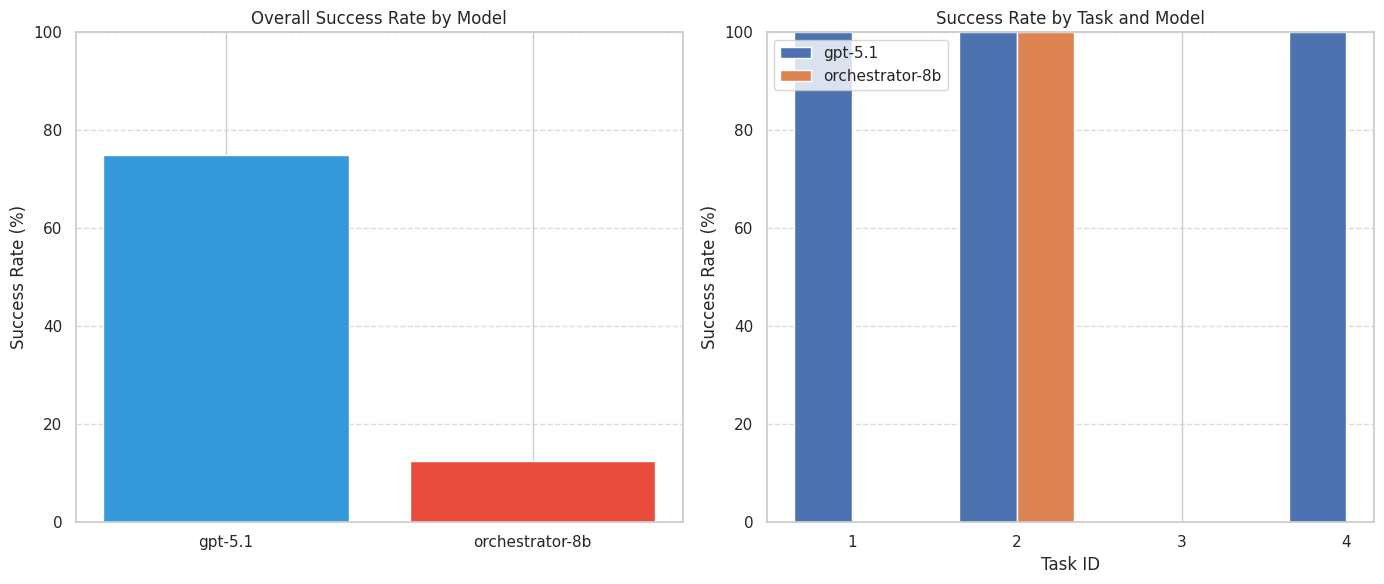

In [9]:
# Load results
df = pd.read_csv("experiment_results.csv")
print(f"Loaded {len(df)} results from CSV")
if 'model' in df.columns:
    print(f"Models: {df['model'].value_counts().to_dict()}")

# 1. Success Rate Comparison
if not df.empty and 'model' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Overall success rate by model
    model_success = df.groupby('model')['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100)
    axes[0].bar(model_success.index, model_success.values, color=['#3498db', '#e74c3c'])
    axes[0].set_title('Overall Success Rate by Model')
    axes[0].set_ylabel('Success Rate (%)')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Success rate by task and model
    task_model_success = df.groupby(['task_id', 'model'])['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100).reset_index()
    task_model_pivot = task_model_success.pivot(index='task_id', columns='model', values='status')
    
    x = range(len(task_model_pivot.index))
    width = 0.35
    models = task_model_pivot.columns.tolist()
    for i, model in enumerate(models):
        offset = (i - len(models)/2 + 0.5) * width
        axes[1].bar([xi + offset for xi in x], task_model_pivot[model], width, label=model)
    axes[1].set_xlabel('Task ID')
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Success Rate by Task and Model')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(task_model_pivot.index)
    axes[1].legend()
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No model column found.")


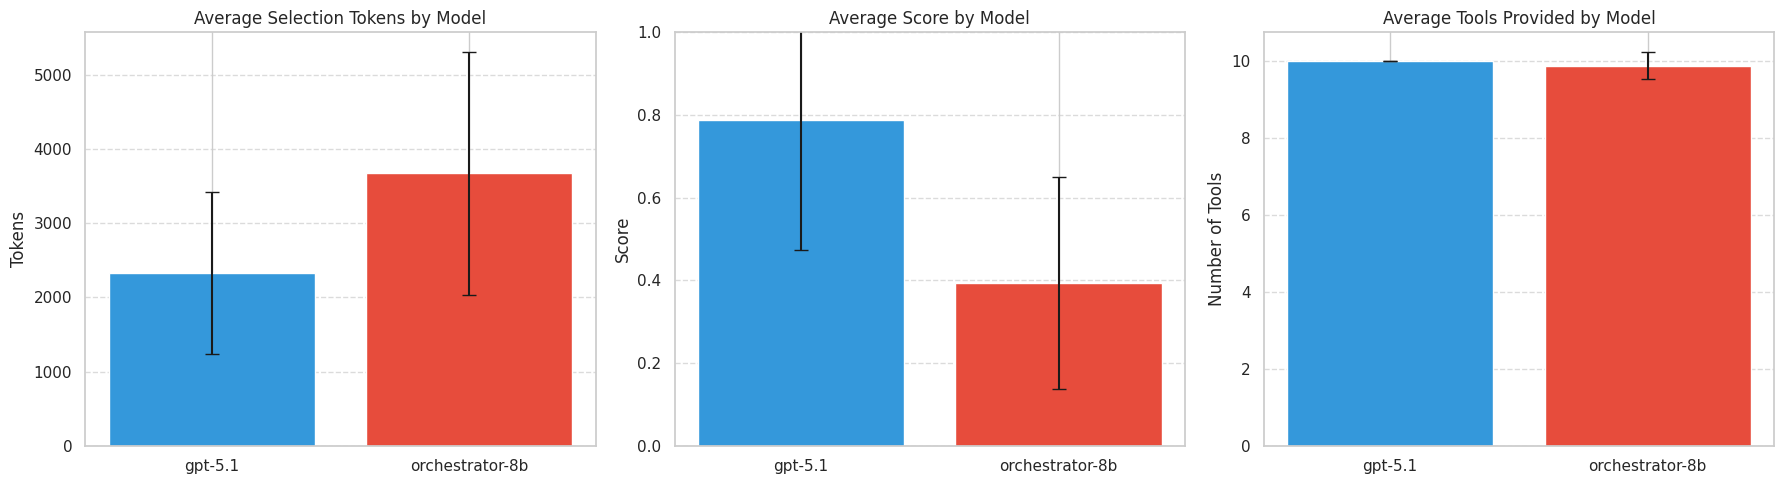

In [10]:
# 2. Token Usage & Performance Comparison
if not df.empty and 'model' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Selection tokens
    if 'selection_input_tokens' in df.columns and 'selection_output_tokens' in df.columns:
        df['total_selection_tokens'] = df['selection_input_tokens'] + df['selection_output_tokens']
        selection_tokens_by_model = df.groupby('model')['total_selection_tokens'].agg(['mean', 'std'])
        axes[0].bar(selection_tokens_by_model.index, selection_tokens_by_model['mean'], 
                   yerr=selection_tokens_by_model['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[0].set_title('Average Selection Tokens by Model')
        axes[0].set_ylabel('Tokens')
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Average score
    if 'score' in df.columns:
        score_by_model = df.groupby('model')['score'].agg(['mean', 'std'])
        axes[1].bar(score_by_model.index, score_by_model['mean'], 
                   yerr=score_by_model['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[1].set_title('Average Score by Model')
        axes[1].set_ylabel('Score')
        axes[1].set_ylim(0, 1)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Tools provided
    if 'tools_provided' in df.columns:
        tools_by_model = df.groupby('model')['tools_provided'].agg(['mean', 'std'])
        axes[2].bar(tools_by_model.index, tools_by_model['mean'], 
                   yerr=tools_by_model['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[2].set_title('Average Tools Provided by Model')
        axes[2].set_ylabel('Number of Tools')
        axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No model column found.")


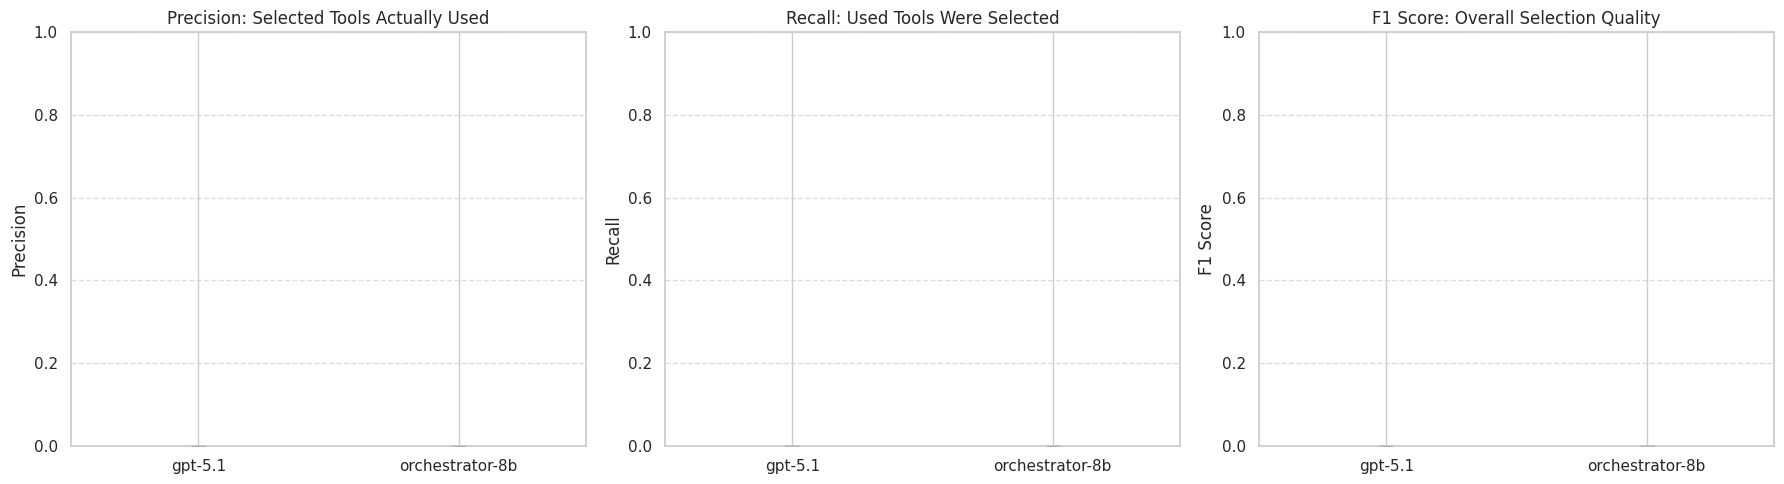


=== Tool Selection Quality Summary ===
                precision      recall        f1     
                     mean  std   mean  std mean  std
model                                               
gpt-5.1               0.0  0.0    0.0  0.0  0.0  0.0
orchestrator-8b       0.0  0.0    0.0  0.0  0.0  0.0


In [11]:
# 3. Model Performance Metrics
if not df.empty and 'model' in df.columns:
    # Analyze which tools were actually used vs selected
    from ast import literal_eval
    
    def parse_tool_calls(tool_calls_str):
        """Parse tool_calls string to list."""
        if pd.isna(tool_calls_str):
            return []
        if isinstance(tool_calls_str, str):
            try:
                return literal_eval(tool_calls_str)
            except:
                return []
        return tool_calls_str if isinstance(tool_calls_str, list) else []
    
    df['tool_calls_list'] = df['tool_calls'].apply(parse_tool_calls)
    
    # Calculate precision and recall for each model
    # Note: This analysis requires 'selected_tools' column which may not exist
    # If it doesn't exist, we'll use 'tools_provided' as a proxy
    results_analysis = []
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        
        for idx, row in model_df.iterrows():
            # Check if 'selected_tools' exists, otherwise use tools_provided
            if 'selected_tools' in row and pd.notna(row.get('selected_tools')):
                selected = set(parse_tool_calls(row.get('selected_tools', '[]')))
            else:
                # Use tools_provided as proxy (all provided tools are considered "selected")
                selected = set(range(row.get('tools_provided', 0)))
            
            used = set(row['tool_calls_list'])
            
            if len(selected) > 0:
                precision = len(used & selected) / len(selected)
            else:
                precision = 0
            
            if len(used) > 0:
                recall = len(used & selected) / len(used)
            else:
                recall = 0
            
            results_analysis.append({
                'model': model,
                'task_id': row['task_id'],
                'precision': precision,
                'recall': recall,
                'f1': 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0,
                'selected_count': len(selected),
                'used_count': len(used),
                'overlap': len(used & selected)
            })
    
    analysis_df = pd.DataFrame(results_analysis)
    
    if not analysis_df.empty:
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Precision by model
        precision_by_model = analysis_df.groupby('model')['precision'].agg(['mean', 'std'])
        axes[0].bar(precision_by_model.index, precision_by_model['mean'], 
                   yerr=precision_by_model['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[0].set_title('Precision: Selected Tools Actually Used')
        axes[0].set_ylabel('Precision')
        axes[0].set_ylim(0, 1)
        axes[0].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Recall by model
        recall_by_model = analysis_df.groupby('model')['recall'].agg(['mean', 'std'])
        axes[1].bar(recall_by_model.index, recall_by_model['mean'], 
                   yerr=recall_by_model['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[1].set_title('Recall: Used Tools Were Selected')
        axes[1].set_ylabel('Recall')
        axes[1].set_ylim(0, 1)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)
        
        # F1 Score by model
        f1_by_model = analysis_df.groupby('model')['f1'].agg(['mean', 'std'])
        axes[2].bar(f1_by_model.index, f1_by_model['mean'], 
                   yerr=f1_by_model['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[2].set_title('F1 Score: Overall Selection Quality')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_ylim(0, 1)
        axes[2].grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n=== Tool Selection Quality Summary ===")
        print(analysis_df.groupby('model')[['precision', 'recall', 'f1']].agg(['mean', 'std']))
    else:
        print("⚠️ No data available for tool selection analysis.")
else:
    print("⚠️ Missing required columns for tool selection analysis.")


## Summary Analysis & Conclusions

Compare GPT-5.1 vs Orchestrator-8B performance across all metrics.


EXPERIMENT SUMMARY: GPT-5.1 vs ORCHESTRATOR-8B

📊 Overall Performance Metrics:
                  status    score           tools_provided            \
                <lambda>     mean       std           mean       std   
model                                                                  
gpt-5.1             75.0  0.78750  0.312783         10.000  0.000000   
orchestrator-8b     12.5  0.39375  0.256957          9.875  0.353553   

                tool_calls_count           confabulation groundedness  \
                            mean       std      <lambda>     <lambda>   
model                                                                   
gpt-5.1                   1.4375  0.963933           0.0        81.25   
orchestrator-8b           3.1250  2.167124           0.0        50.00   

                total_selection_tokens               
                                  mean          std  
model                                                
gpt-5.1                       23

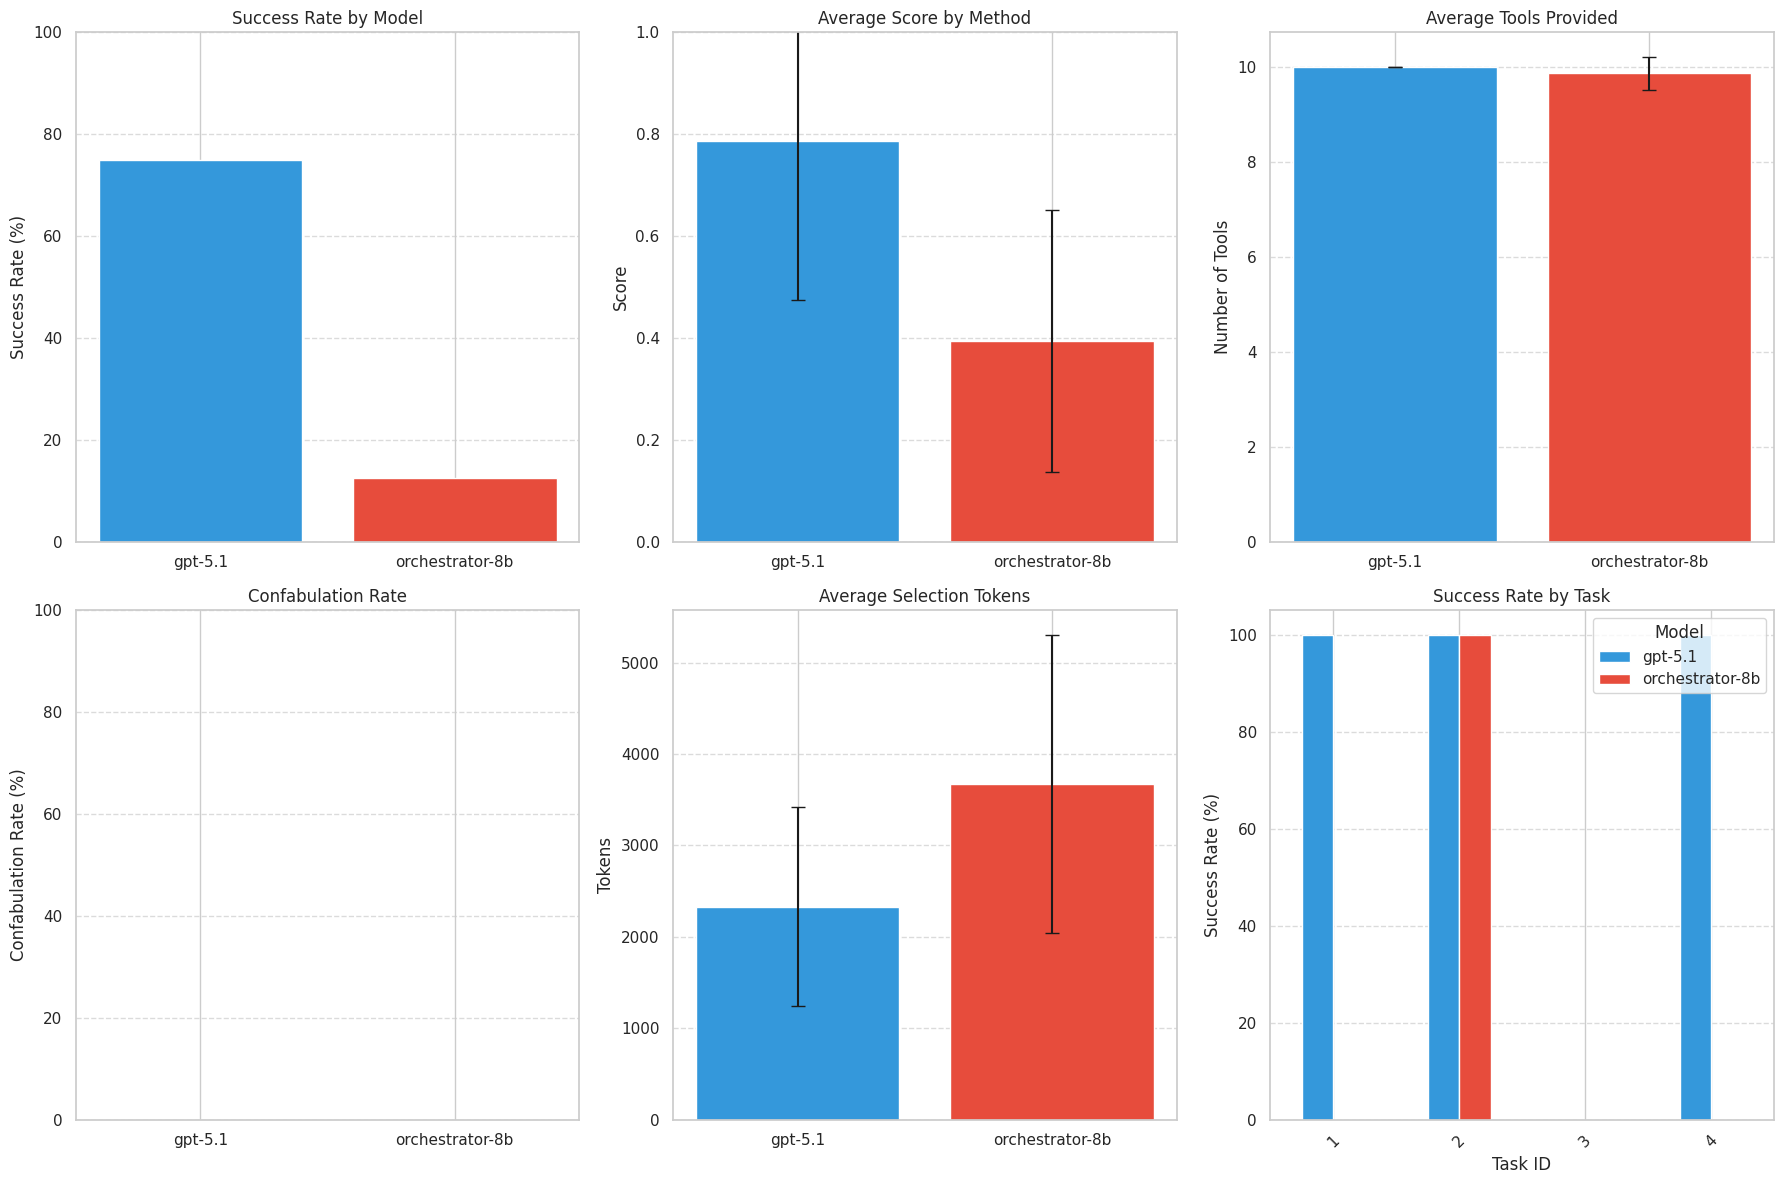


🔍 Missing Tools Analysis:
                missing_count        
                         mean max sum
model                                
gpt-5.1                 1.125   3  18
orchestrator-8b         1.750   3  14

⚠️ Tasks with missing tools:
  gpt-5.1 - Task 1: Missing ['GOOGLESHEETS_BATCH_UPDATE', 'GOOGLEDOCS_GET_DOCUMENT_BY_ID']
  gpt-5.1 - Task 1: Missing ['GOOGLESHEETS_BATCH_UPDATE', 'GOOGLESHEETS_BATCH_GET', 'GOOGLEDOCS_GET_DOCUMENT_BY_ID']
  gpt-5.1 - Task 1: Missing ['GOOGLESHEETS_BATCH_UPDATE', 'GOOGLEDOCS_GET_DOCUMENT_BY_ID']
  gpt-5.1 - Task 1: Missing ['GOOGLESHEETS_BATCH_UPDATE', 'GOOGLEDOCS_GET_DOCUMENT_BY_ID']
  gpt-5.1 - Task 2: Missing ['GMAIL_SEND_EMAIL']
  gpt-5.1 - Task 2: Missing ['GMAIL_SEND_EMAIL']
  gpt-5.1 - Task 2: Missing ['GMAIL_SEND_EMAIL']
  gpt-5.1 - Task 2: Missing ['GMAIL_SEND_EMAIL']
  gpt-5.1 - Task 3: Missing ['TELEGRAM_GET_UPDATES']
  gpt-5.1 - Task 4: Missing ['TWITTER_RECENT_SEARCH']
  gpt-5.1 - Task 4: Missing ['TWITTER_RECENT_SEARCH']
  gpt-

In [12]:
# Comprehensive Comparison Summary
if not df.empty and 'model' in df.columns:
    print("=" * 60)
    print("EXPERIMENT SUMMARY: GPT-5.1 vs ORCHESTRATOR-8B")
    print("=" * 60)
    
    # Overall statistics by model
    summary_stats = df.groupby('model').agg({
        'status': lambda x: (x == 'PASS').sum() / len(x) * 100,
        'score': ['mean', 'std'],
        'tools_provided': ['mean', 'std'],
        'tool_calls_count': ['mean', 'std'],
        'confabulation': lambda x: x.sum() / len(x) * 100,
        'groundedness': lambda x: x.sum() / len(x) * 100,
    })
    
    if 'selection_input_tokens' in df.columns:
        df['total_selection_tokens'] = df['selection_input_tokens'] + df['selection_output_tokens']
        token_stats = df.groupby('model')['total_selection_tokens'].agg(['mean', 'std'])
        summary_stats[('total_selection_tokens', 'mean')] = token_stats['mean']
        summary_stats[('total_selection_tokens', 'std')] = token_stats['std']
    
    print("\n📊 Overall Performance Metrics:")
    print(summary_stats)
    
    # Create comprehensive comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Success Rate
    success_rates = df.groupby('model')['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100)
    axes[0, 0].bar(success_rates.index, success_rates.values, color=['#3498db', '#e74c3c'])
    axes[0, 0].set_title('Success Rate by Model')
    axes[0, 0].set_ylabel('Success Rate (%)')
    axes[0, 0].set_ylim(0, 100)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Average Score
    score_stats = df.groupby('model')['score'].agg(['mean', 'std'])
    axes[0, 1].bar(score_stats.index, score_stats['mean'], 
                   yerr=score_stats['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[0, 1].set_title('Average Score by Method')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 3. Tools Provided
    tools_stats = df.groupby('model')['tools_provided'].agg(['mean', 'std'])
    axes[0, 2].bar(tools_stats.index, tools_stats['mean'], 
                   yerr=tools_stats['std'], capsize=5, color=['#3498db', '#e74c3c'])
    axes[0, 2].set_title('Average Tools Provided')
    axes[0, 2].set_ylabel('Number of Tools')
    axes[0, 2].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 4. Confabulation Rate
    confab_rates = df.groupby('model')['confabulation'].apply(lambda x: x.sum() / len(x) * 100)
    axes[1, 0].bar(confab_rates.index, confab_rates.values, color=['#3498db', '#e74c3c'])
    axes[1, 0].set_title('Confabulation Rate')
    axes[1, 0].set_ylabel('Confabulation Rate (%)')
    axes[1, 0].set_ylim(0, max(100, confab_rates.max() * 1.1))
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 5. Token Usage (if available)
    if 'total_selection_tokens' in df.columns:
        token_stats = df.groupby('model')['total_selection_tokens'].agg(['mean', 'std'])
        axes[1, 1].bar(token_stats.index, token_stats['mean'], 
                       yerr=token_stats['std'], capsize=5, color=['#3498db', '#e74c3c'])
        axes[1, 1].set_title('Average Selection Tokens')
        axes[1, 1].set_ylabel('Tokens')
        axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    else:
        axes[1, 1].text(0.5, 0.5, 'Token data\nnot available', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Token Usage')
    
    # 6. Task Success Distribution
    task_success = df.groupby(['task_id', 'model'])['status'].apply(lambda x: (x == 'PASS').sum() / len(x) * 100).unstack()
    task_success.plot(kind='bar', ax=axes[1, 2], color=['#3498db', '#e74c3c'])
    axes[1, 2].set_title('Success Rate by Task')
    axes[1, 2].set_ylabel('Success Rate (%)')
    axes[1, 2].set_xlabel('Task ID')
    axes[1, 2].legend(title='Model')
    axes[1, 2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Missing tools analysis
    print("\n🔍 Missing Tools Analysis:")
    from ast import literal_eval
    
    def parse_list_field(field_str):
        if pd.isna(field_str):
            return []
        if isinstance(field_str, str):
            try:
                return literal_eval(field_str)
            except:
                return []
        return field_str if isinstance(field_str, list) else []
    
    missing_analysis = []
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        for idx, row in model_df.iterrows():
            selected = set(parse_list_field(row.get('selected_tools', '[]')))
            used = set(parse_list_field(row.get('tool_calls', '[]')))
            missing = used - selected
            
            missing_analysis.append({
                'model': model,
                'task_id': row['task_id'],
                'missing_count': len(missing),
                'missing_tools': list(missing)
            })
    
    missing_df = pd.DataFrame(missing_analysis)
    if not missing_df.empty:
        missing_summary = missing_df.groupby('model').agg({
            'missing_count': ['mean', 'max', 'sum']
        })
        print(missing_summary)
        
        # Show tasks with missing tools
        tasks_with_missing = missing_df[missing_df['missing_count'] > 0]
        if not tasks_with_missing.empty:
            print("\n⚠️ Tasks with missing tools:")
            for idx, row in tasks_with_missing.iterrows():
                print(f"  {row['model']} - Task {row['task_id']}: Missing {row['missing_tools']}")
    
    print("\n" + "=" * 60)
else:
    print("⚠️ No data available for summary. Run the experiment first.")



📋 Task-by-Task Detailed Comparison:

Task 1: Port a table present in Google Docs to Google Sheets. Docume...
  GPT-5.1:
    Success Rate: 100.0%
    Avg Score: 1.00
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 3545
  ORCHESTRATOR-8B:
    Success Rate: 0.0%
    Avg Score: 0.20
    Avg Tools Provided: 9.8
    Avg Selection Tokens: 5168

Task 2: remind akshay@getseer.dev to buy some groceries...
  GPT-5.1:
    Success Rate: 100.0%
    Avg Score: 0.99
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 1690
  ORCHESTRATOR-8B:
    Success Rate: 100.0%
    Avg Score: 0.90
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 2864

Task 3: send good morning message to +1 646-371-6198 via telegram...
  GPT-5.1:
    Success Rate: 0.0%
    Avg Score: 0.28
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 950
  ORCHESTRATOR-8B:
    Success Rate: 0.0%
    Avg Score: 0.48
    Avg Tools Provided: 10.0
    Avg Selection Tokens: 1945

Task 4: what are the latest trends going on twi

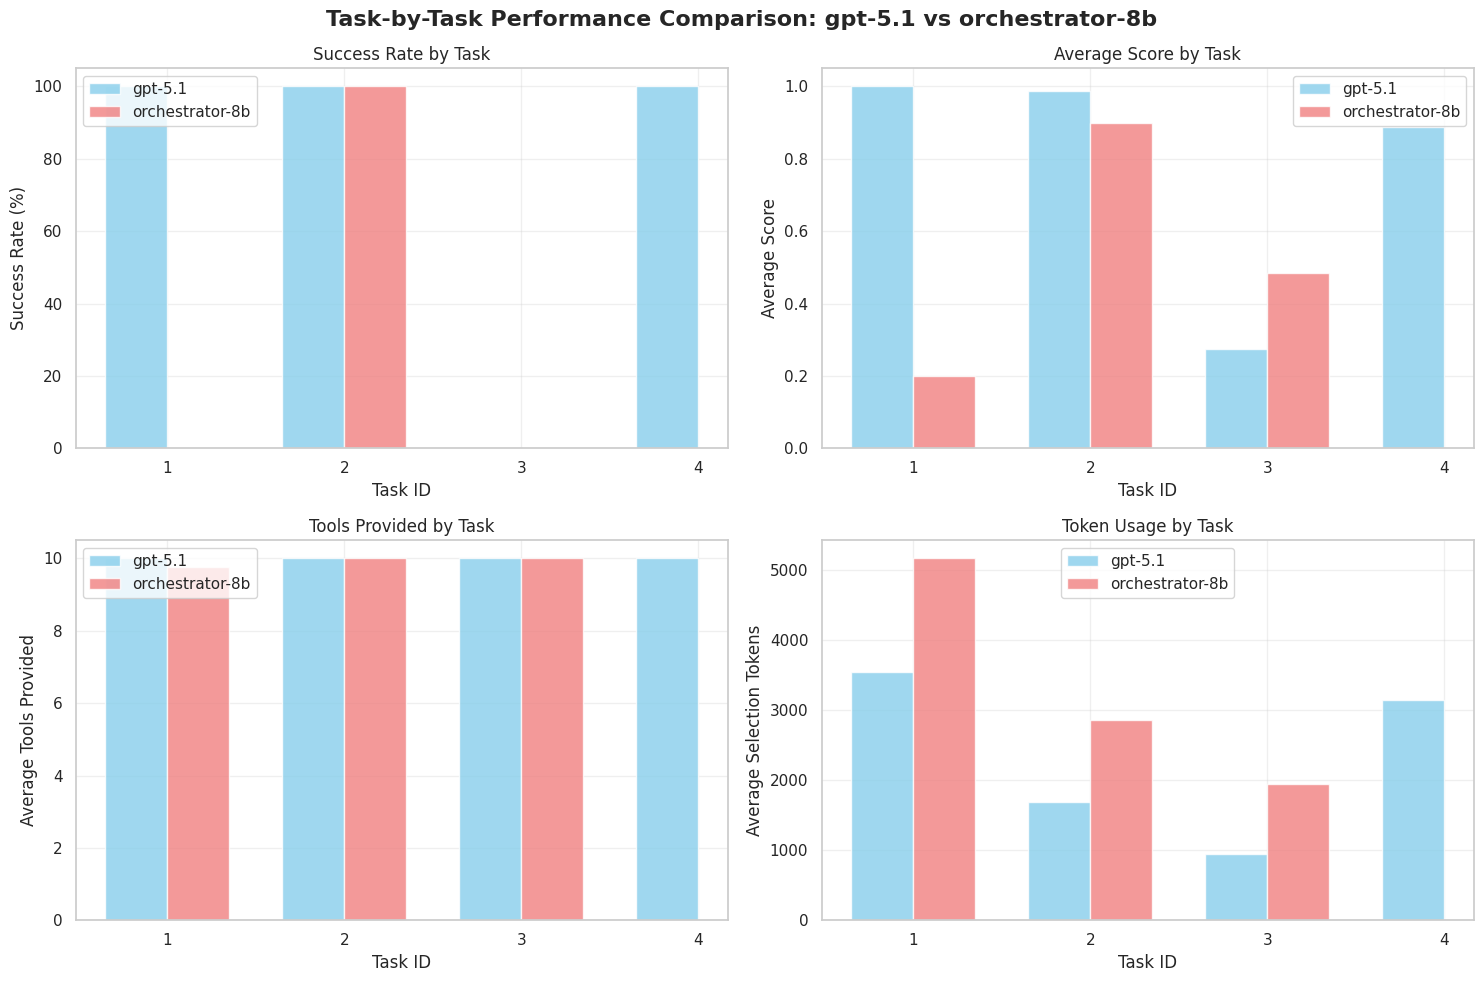

In [13]:
# Additional Analysis: Detailed Task-by-Task Comparison with Visualization
if not df.empty and 'model' in df.columns:
    print("\n📋 Task-by-Task Detailed Comparison:")
    print("=" * 60)
    
    # Collect data for plotting
    task_comparison_data = []
    models = df['model'].unique().tolist()
    
    for task_id in sorted(df['task_id'].unique()):
        task_df = df[df['task_id'] == task_id]
        print(f"\nTask {task_id}: {TASKS[task_id-1]['instruction'][:60]}...")
        
        task_data = {'task_id': task_id}
        
        for model in models:
            model_task_df = task_df[task_df['model'] == model]
            if not model_task_df.empty:
                success_rate = (model_task_df['status'] == 'PASS').sum() / len(model_task_df) * 100
                avg_score = model_task_df['score'].mean()
                avg_tools = model_task_df['tools_provided'].mean()
                
                print(f"  {model.upper()}:")
                print(f"    Success Rate: {success_rate:.1f}%")
                print(f"    Avg Score: {avg_score:.2f}")
                print(f"    Avg Tools Provided: {avg_tools:.1f}")
                
                # Store data for plotting (use model name as key)
                model_key = model.replace('-', '_').replace('.', '_')
                task_data[f'{model_key}_success_rate'] = success_rate
                task_data[f'{model_key}_avg_score'] = avg_score
                task_data[f'{model_key}_avg_tools'] = avg_tools
                
                if 'total_selection_tokens' in model_task_df.columns:
                    avg_tokens = model_task_df['total_selection_tokens'].mean()
                    print(f"    Avg Selection Tokens: {avg_tokens:.0f}")
                    task_data[f'{model_key}_avg_tokens'] = avg_tokens
        
        task_comparison_data.append(task_data)
    
    # Create visualization
    if task_comparison_data and len(models) >= 2:
        import matplotlib.pyplot as plt
        import numpy as np
        
        task_comp_df = pd.DataFrame(task_comparison_data)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Task-by-Task Performance Comparison: {" vs ".join(models)}', fontsize=16, fontweight='bold')
        
        # Success Rate Comparison
        ax1 = axes[0, 0]
        x = np.arange(len(task_comp_df))
        width = 0.35
        
        model1_key = models[0].replace('-', '_').replace('.', '_')
        model2_key = models[1].replace('-', '_').replace('.', '_')
        
        model1_success = task_comp_df.get(f'{model1_key}_success_rate', [0] * len(task_comp_df))
        model2_success = task_comp_df.get(f'{model2_key}_success_rate', [0] * len(task_comp_df))
        
        ax1.bar(x - width/2, model1_success, width, label=models[0], color='skyblue', alpha=0.8)
        ax1.bar(x + width/2, model2_success, width, label=models[1], color='lightcoral', alpha=0.8)
        ax1.set_xlabel('Task ID')
        ax1.set_ylabel('Success Rate (%)')
        ax1.set_title('Success Rate by Task')
        ax1.set_xticks(x)
        ax1.set_xticklabels(task_comp_df['task_id'])
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Average Score Comparison
        ax2 = axes[0, 1]
        model1_scores = task_comp_df.get(f'{model1_key}_avg_score', [0] * len(task_comp_df))
        model2_scores = task_comp_df.get(f'{model2_key}_avg_score', [0] * len(task_comp_df))
        
        ax2.bar(x - width/2, model1_scores, width, label=models[0], color='skyblue', alpha=0.8)
        ax2.bar(x + width/2, model2_scores, width, label=models[1], color='lightcoral', alpha=0.8)
        ax2.set_xlabel('Task ID')
        ax2.set_ylabel('Average Score')
        ax2.set_title('Average Score by Task')
        ax2.set_xticks(x)
        ax2.set_xticklabels(task_comp_df['task_id'])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Tools Provided Comparison
        ax3 = axes[1, 0]
        model1_tools = task_comp_df.get(f'{model1_key}_avg_tools', [0] * len(task_comp_df))
        model2_tools = task_comp_df.get(f'{model2_key}_avg_tools', [0] * len(task_comp_df))
        
        ax3.bar(x - width/2, model1_tools, width, label=models[0], color='skyblue', alpha=0.8)
        ax3.bar(x + width/2, model2_tools, width, label=models[1], color='lightcoral', alpha=0.8)
        ax3.set_xlabel('Task ID')
        ax3.set_ylabel('Average Tools Provided')
        ax3.set_title('Tools Provided by Task')
        ax3.set_xticks(x)
        ax3.set_xticklabels(task_comp_df['task_id'])
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Token Usage Comparison (if available)
        ax4 = axes[1, 1]
        if f'{model1_key}_avg_tokens' in task_comp_df.columns or f'{model2_key}_avg_tokens' in task_comp_df.columns:
            model1_tokens = task_comp_df.get(f'{model1_key}_avg_tokens', [0] * len(task_comp_df))
            model2_tokens = task_comp_df.get(f'{model2_key}_avg_tokens', [0] * len(task_comp_df))
            
            ax4.bar(x - width/2, model1_tokens, width, label=models[0], color='skyblue', alpha=0.8)
            ax4.bar(x + width/2, model2_tokens, width, label=models[1], color='lightcoral', alpha=0.8)
            ax4.set_xlabel('Task ID')
            ax4.set_ylabel('Average Selection Tokens')
            ax4.set_title('Token Usage by Task')
            ax4.set_xticks(x)
            ax4.set_xticklabels(task_comp_df['task_id'])
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Token data not available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Token Usage by Task')
        
        plt.tight_layout()
        plt.show()
    elif len(models) < 2:
        print("⚠️ Need at least 2 models for comparison.")
        
else:
    print("⚠️ No data available.")